# Configurações e treinamento da rede neural

In [43]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sagemaker
from sagemaker import get_execution_role

In [44]:
bucket = 'redeneural'
subpasta_dataset = 'mnist'
session = sagemaker.Session()
role = get_execution_role()
region = session.boto_session.region_name
base_treinamento = 's3://sagemaker-sample-data-{}/tensorflow/mnist'.format(region)
output_location = 's3://{}/{}/output-tf'.format(bucket, subpasta_dataset)
print('Localização da base de treinamento: ', base_treinamento)
print('Região: ', region)
print('Localização do modelo: ', output_location)

Localização da base de treinamento:  s3://sagemaker-sample-data-us-east-1/tensorflow/mnist
Região:  us-east-1
Localização do modelo:  s3://redeneural/mnist/output-tf


In [45]:
# https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html
from sagemaker.tensorflow import TensorFlow
mnist_tensorflow = TensorFlow(entry_point = "mnist.py",
                              role = role,
                              instance_count = 1,
                              instance_type = 'ml.p3.2xlarge',
                              framework_version = '2.5',
                              py_version = 'py37',
                              output_path = output_location,
                              hyperparameter = {'epochs': 20, 'batch_size': 128, 
                                                'learning-rate': 0.001,
                                                'dropout': 1})

In [46]:
mnist_tensorflow.fit(base_treinamento)

2022-06-03 01:51:21 Starting - Starting the training job...
2022-06-03 01:51:48 Starting - Preparing the instances for trainingProfilerReport-1654221081: InProgress
.........
2022-06-03 01:53:21 Downloading - Downloading input data
2022-06-03 01:53:21 Training - Downloading the training image..................
2022-06-03 01:56:08 Training - Training image download completed. Training in progress.2022-06-03 01:56:05.800480: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-06-03 01:56:05.804791: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2022-06-03 01:56:05.897472: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-06-03 01:56:05.993421: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the Sa

In [19]:
!pygmentize mnist.py

# https://docs.aws.amazon.com/sagemaker/latest/dg/pre-built-containers-frameworks-deep-learning.html

import argparse
import json
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

if __name__ == "__main__":
    # https://docs.python.org/3/howto/argparse.html
    parser = argparse.ArgumentParser()
    
    parser.add_argument('--epochs', type=int, default=2)
    parser.add_argument('--learning-rate', type=float, default=0.001)
    parser.add_argument('--batch-size', type=int, default=32)
    
    # https://github.com/aws/sagemaker-training-toolkit/blob/master/ENVIRONMENT_VARIABLES.md
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAINING'))
    parser.add_argument('--model-dir', type=str)
    parser.add_argument('--sm-model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    
    args, _ = parser.parse_known_a

# Deploy e previsões

In [30]:
classificador_mnist = mnist_tensorflow.deploy(initial_instance_count = 1,
                                              instance_type = 'ml.p2.xlarge')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-------------!

In [21]:
!aws --region {region} s3 cp s3://sagemaker-sample-data-{region}/tensorflow/mnist/eval_data.npy eval_data.npy
!aws --region {region} s3 cp s3://sagemaker-sample-data-{region}/tensorflow/mnist/eval_labels.npy eval_labels.npy

download: s3://sagemaker-sample-data-us-east-1/tensorflow/mnist/eval_data.npy to ./eval_data.npy
download: s3://sagemaker-sample-data-us-east-1/tensorflow/mnist/eval_labels.npy to ./eval_labels.npy


In [22]:
X_teste = np.load('eval_data.npy')
y_teste = np.load('eval_labels.npy')

In [23]:
X_teste.shape, y_teste.shape

((10000, 784), (10000,))

In [24]:
type(X_teste), type(y_teste)

(numpy.ndarray, numpy.ndarray)

In [25]:
X_teste[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [31]:
y_teste[0]

7

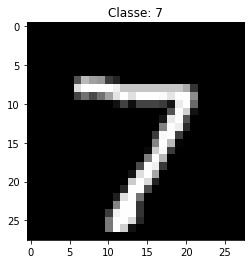

In [32]:
plt.imshow(X_teste[0].reshape(28,28), cmap='gray')
plt.title('Classe: ' + str(y_teste[0]));

In [33]:
previsao = classificador_mnist.predict(X_teste[0])
previsao

{'predictions': [[1.52251811e-09,
   1.09362205e-07,
   1.27409076e-05,
   2.01284229e-06,
   2.03230793e-10,
   3.91953803e-09,
   2.51150229e-12,
   0.99998486,
   1.04240092e-08,
   1.77889945e-07]]}

In [34]:
previsao = previsao['predictions']
previsao

[[1.52251811e-09,
  1.09362205e-07,
  1.27409076e-05,
  2.01284229e-06,
  2.03230793e-10,
  3.91953803e-09,
  2.51150229e-12,
  0.99998486,
  1.04240092e-08,
  1.77889945e-07]]

In [35]:
np.argmax(previsao)

7